In [1]:
# --- Imports ---
import sys, os
sys.path.append(os.path.abspath(".."))  # make `src` importable

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from src import load_bcn20000, get_transforms, SimpleCNN

In [2]:
# --- Device selection (CPU / CUDA / MPS) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)
device

mps


device(type='mps')

In [3]:
# --- Binary mapping setup ---
malignant = {"MEL", "SCC", "BCC"}
all_labels = ["MEL", "SCC", "NV", "BCC", "BKL", "AK", "DF", "VASC"]
label_mapping = {lbl: ("malignant" if lbl in malignant else "benign") for lbl in all_labels}

# --- Train/Val with labels ---
train_hf = load_bcn20000(split="train",
                         filename_column="bcn_filename",
                         label_column="diagnosis",
                         label_mapping=label_mapping)
val_hf   = load_bcn20000(split="validation",
                         filename_column="bcn_filename",
                         label_column="diagnosis",
                         label_mapping=label_mapping)

# --- Test WITHOUT labels (common on Kaggle) ---
test_hf  = load_bcn20000(split="test",
                         filename_column="bcn_filename",
                         label_column=None,
                         label_mapping=None)

label_names = train_hf.features["label"].names
num_classes = len(label_names)
(len(train_hf), len(val_hf), len(test_hf), num_classes, label_names)

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6501 [00:00<?, ? examples/s]

(12413, 1240, 6501, 2, ['benign', 'malignant'])

In [4]:
# --- Torch wrapper dataset ---
class TorchImageDataset(Dataset):
    def __init__(self, hf_ds, transform, has_labels=True):
        self.ds = hf_ds
        self.tf = transform
        self.has_labels = has_labels
        self.label_feature = hf_ds.features["label"] if has_labels else None

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.open(img).convert("RGB")
        x = self.tf(img)
        if self.has_labels:
            y = ex["label"]
            if isinstance(y, str):
                y = self.label_feature.str2int(y)
            else:
                y = int(y)
            return x, y
        else:
            return x

In [5]:
# --- Transforms and DataLoaders ---
train_tf = get_transforms(train=True)
eval_tf = get_transforms(train=False)

train_ds = TorchImageDataset(train_hf, train_tf, has_labels=True)
val_ds   = TorchImageDataset(val_hf,   eval_tf,  has_labels=True)
test_ds  = TorchImageDataset(test_hf,  eval_tf,  has_labels=False)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

bx = next(iter(train_loader))
bx[0].shape, bx[1].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [6]:
# --- Model / Loss / Optimizer ---
model = SimpleCNN(num_classes=num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5  # start small to verify pipeline

In [7]:
# --- Training + validation loop with progress bars ---
def evaluate(model, data_loader, device):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    has_labels = True
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                x, y = batch
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                running_loss += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
            else:
                has_labels = False
                x = batch.to(device)
                out = model(x)
    if not has_labels:
        return None, None
    avg_loss = running_loss / max(1, len(data_loader))
    acc = correct / max(1, total)
    return avg_loss, acc

train_history = {"loss": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0
os.makedirs("../artifacts/checkpoints", exist_ok=True)
ckpt_path = "../artifacts/checkpoints/simplecnn_best.pt"

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    # progress bar over training batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=True)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_train_loss = running_loss / max(1, len(train_loader))
    val_loss, val_acc = evaluate(model, val_loader, device)

    train_history["loss"].append(avg_train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}: loss={avg_train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"state_dict": model.state_dict(), "val_acc": best_val_acc}, ckpt_path)
        print(f"Saved new best checkpoint to {ckpt_path} (val_acc={best_val_acc:.4f})")

Epoch 1/5:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 1: loss=0.6812 | val_loss=0.6170 | val_acc=0.6565
Saved new best checkpoint to ../artifacts/checkpoints/simplecnn_best.pt (val_acc=0.6565)


Epoch 2/5:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 2: loss=0.6245 | val_loss=0.6227 | val_acc=0.6750
Saved new best checkpoint to ../artifacts/checkpoints/simplecnn_best.pt (val_acc=0.6750)


Epoch 3/5:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 3: loss=0.6131 | val_loss=0.6345 | val_acc=0.6685


Epoch 4/5:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 4: loss=0.6041 | val_loss=0.5937 | val_acc=0.6798
Saved new best checkpoint to ../artifacts/checkpoints/simplecnn_best.pt (val_acc=0.6798)


Epoch 5/5:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 5: loss=0.5991 | val_loss=0.5884 | val_acc=0.6879
Saved new best checkpoint to ../artifacts/checkpoints/simplecnn_best.pt (val_acc=0.6879)


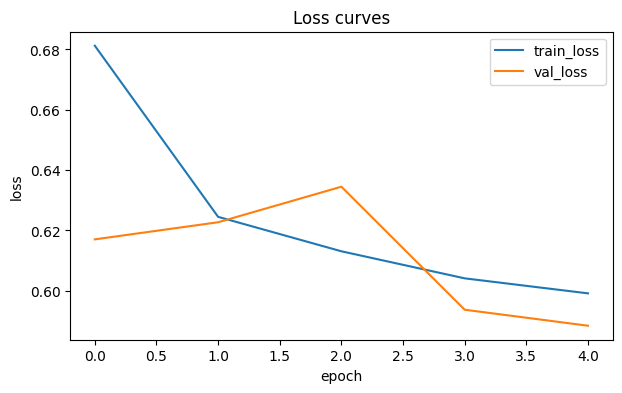

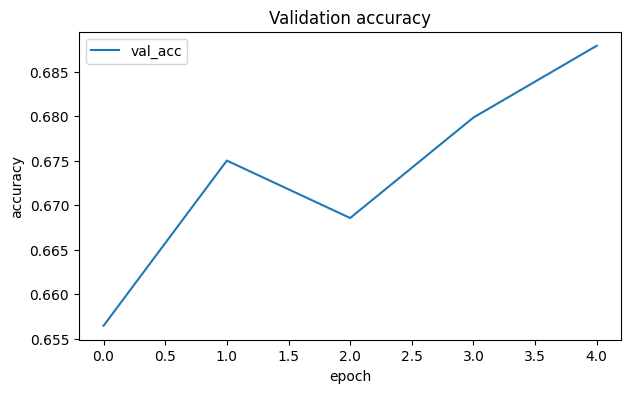

In [8]:
# --- Plot learning curves ---
plt.figure(figsize=(7,4))
plt.plot(train_history["loss"], label="train_loss")
plt.plot(train_history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss curves")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(train_history["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Validation accuracy")
plt.show()

In [9]:
# --- Load best checkpoint and evaluate on test set ---
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"])

test_loss, test_acc = evaluate(model, test_loader, device)
if test_loss is None:
    print("Test split has no labels; running inference only.")
else:
    print("Test metrics:", test_loss, test_acc)

Test split has no labels; running inference only.


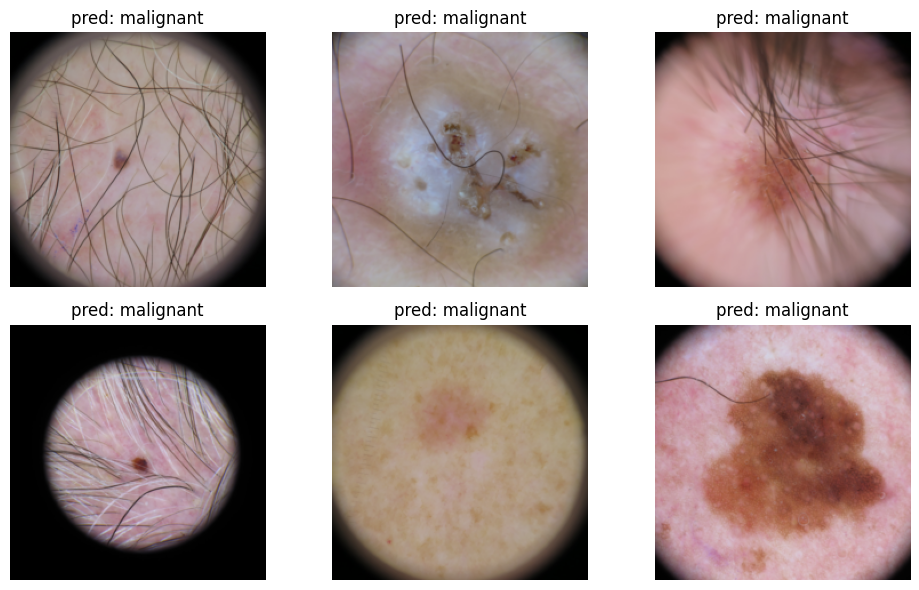

In [10]:
# --- Inference preview ---
model.eval()
x = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    out = model(x)
preds = out.argmax(dim=1).cpu()

# show a few predictions
n = min(6, x.size(0))
fig, axes = plt.subplots(2, (n + 1)//2, figsize=(10,6))
axes = axes.flatten()
for i in range(n):
    img = x[i].detach().cpu()
    img = (img * 0.5) + 0.5
    img = img.permute(1,2,0).clamp(0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"pred: {label_names[int(preds[i])]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()